In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dpk938","key":"1d7dda4e36432d6b396fb9f272bf6012"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d mikoaro/distracteddriver

Dataset URL: https://www.kaggle.com/datasets/mikoaro/distracteddriver
License(s): GPL-2.0
100% 3.99G/4.01G [01:41<00:00, 33.7MB/s]
100% 4.01G/4.01G [01:42<00:00, 42.1MB/s]


In [ ]:
!unzip *.zip

Streaming output truncated to the last 5000 lines.
  inflating: distracted-driver-detection/train/c7/img_566.jpg  
  inflating: distracted-driver-detection/train/c7/img_56636.jpg  
  inflating: distracted-driver-detection/train/c7/img_56661.jpg  
  inflating: distracted-driver-detection/train/c7/img_56699.jpg  
  inflating: distracted-driver-detection/train/c7/img_56717.jpg  
  inflating: distracted-driver-detection/train/c7/img_56724.jpg  
  inflating: distracted-driver-detection/train/c7/img_56768.jpg  
  inflating: distracted-driver-detection/train/c7/img_56779.jpg  
  inflating: distracted-driver-detection/train/c7/img_56849.jpg  
  inflating: distracted-driver-detection/train/c7/img_56899.jpg  
  inflating: distracted-driver-detection/train/c7/img_56938.jpg  
  inflating: distracted-driver-detection/train/c7/img_5706.jpg  
  inflating: distracted-driver-detection/train/c7/img_57076.jpg  
  inflating: distracted-driver-detection/train/c7/img_57122.jpg  
  inflating: distracted-driv

rm: cannot remove '/content/distracted-driver-detection/train/c5': No such file or directory


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
100%|██████████| 477/477 [03:08<00:00,  2.53it/s]



✨ Final Accuracy with Penalty + Augmentation: 0.7900


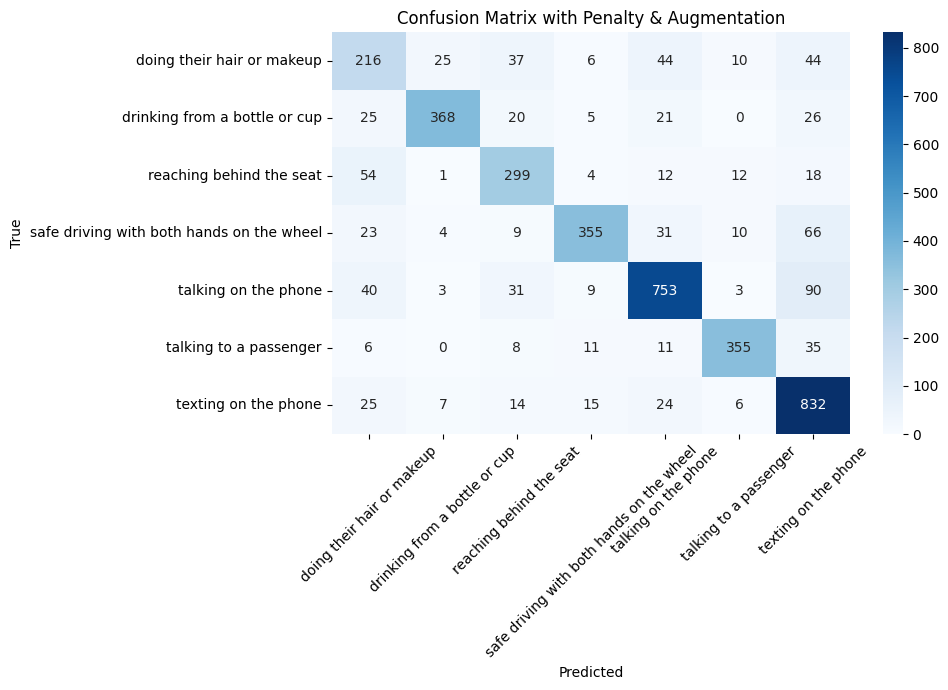

In [ ]:
# clip with optimized clustering
# STEP 1: Setup
# ============================

import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import torch
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm
import mediapipe as mp
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

# ============================
# STEP 2: Load & Clean Dataset
# ============================

!rm -r /content/distracted-driver-detection/train/c5  # Remove unused class

os.chdir('/content/distracted-driver-detection/train')
data = []
class_folders = sorted([d for d in os.listdir() if os.path.isdir(d)])

for cls in class_folders:
    for file in os.listdir(cls):
        data.append({
            'image path': os.path.join('/content/distracted-driver-detection/train', cls, file),
            'label': cls
        })

df = pd.DataFrame(data)

label_map = {
    'c0': "safe driving with both hands on the wheel",
    'c1': "texting on the phone",
    'c2': "talking on the phone",
    'c3': "texting on the phone",
    'c4': "talking on the phone",
    'c6': "drinking from a bottle or cup",
    'c7': "reaching behind the seat",
    'c8': "doing their hair or makeup",
    'c9': "talking to a passenger"
}
df['label'] = df['label'].map(label_map)

# ============================
# STEP 3: Read and preprocess images
# ============================

x = []
y = []

for i, row in df.iterrows():
    img_path = row['image path']
    label = row['label']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    x.append(np.array(img))
    y.append(label)

x = np.array(x)
y = np.array(y)

# ============================
# STEP 4: Attention Masking
# ============================

def extract_face_hand_regions(img_np):
    mp_face = mp.solutions.face_detection
    mp_hands = mp.solutions.hands

    img_rgb = img_np.copy()
    h, w, _ = img_rgb.shape
    mask = np.zeros_like(img_rgb)

    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5) as face_det:
        face_results = face_det.process(img_rgb)
        if face_results.detections:
            for det in face_results.detections:
                bbox = det.location_data.relative_bounding_box
                x1 = int(bbox.xmin * w)
                y1 = int(bbox.ymin * h)
                x2 = int((bbox.xmin + bbox.width) * w)
                y2 = int((bbox.ymin + bbox.height) * h)
                mask[y1:y2, x1:x2] = img_rgb[y1:y2, x1:x2]

    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
        hand_results = hands.process(img_rgb)
        if hand_results.multi_hand_landmarks:
            for hand_landmarks in hand_results.multi_hand_landmarks:
                xs = [int(p.x * w) for p in hand_landmarks.landmark]
                ys = [int(p.y * h) for p in hand_landmarks.landmark]
                x1, x2 = max(min(xs) - 20, 0), min(max(xs) + 20, w)
                y1, y2 = max(min(ys) - 20, 0), min(max(ys) + 20, h)
                mask[y1:y2, x1:x2] = img_rgb[y1:y2, x1:x2]

    return mask

# ============================
# STEP 5: CLIP Embedding Extraction
# ============================

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

def extract_features_with_attention(x_images):
    features = []
    for img_np in tqdm(x_images):
        focused_img = extract_face_hand_regions(img_np)
        img = Image.fromarray(focused_img.astype("uint8")).convert("RGB")
        inputs = processor(images=img, return_tensors="pt", do_resize=True, do_center_crop=True).to(device)
        with torch.no_grad():
            img_feat = model.get_image_features(**inputs)
            img_feat = img_feat / img_feat.norm(p=2, dim=-1, keepdim=True)
        features.append(img_feat.cpu().numpy().flatten())
    return np.stack(features)

# ============================
# STEP 6: Split Data
# ============================

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

x_train_feat = extract_features_with_attention(x_train)
x_val_feat = extract_features_with_attention(x_val)

# ============================
# STEP 7: Apply PCA (Dimensionality Reduction)
# ============================

pca = PCA(n_components=100, random_state=42)
x_train_pca = pca.fit_transform(x_train_feat)
x_val_pca = pca.transform(x_val_feat)

# ============================
# STEP 8: Train Classifier
# ============================

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
rf_clf.fit(x_train_pca, y_train)
y_val_pred = rf_clf.predict(x_val_pca)
# Modified version with class weighting + augmentation of misclassified samples

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# STEP 8A: Calculate Class Weights for Penalty
# ============================

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}

# ============================
# STEP 8B: Data Augmentation (for misclassified images)
# ============================

def augment_image(img):
    """Returns a horizontally flipped version of the image."""
    return np.fliplr(img)

# Find misclassified examples on train set itself (pseudo-hard-mining)
y_train_pred = rf_clf.predict(x_train_pca)
conf_mat = confusion_matrix(y_train, y_train_pred, labels=classes)

misclassified_idxs = np.where(y_train_pred != y_train)[0]
x_aug = []
y_aug = []

for idx in misclassified_idxs:
    aug_img = augment_image(x_train[idx])
    x_aug.append(aug_img)
    y_aug.append(y_train[idx])

# Extract features from augmented images
x_aug_feat = extract_features_with_attention(x_aug)
x_aug_pca = pca.transform(x_aug_feat)

# Combine with original data
x_train_combined = np.vstack([x_train_pca, x_aug_pca])
y_train_combined = np.concatenate([y_train, y_aug])

# Optional: oversample
ros = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train_combined, y_train_combined)

# ============================
# STEP 8C: Re-train Classifier with Penalty and Augmentation
# ============================

rf_clf_aug = RandomForestClassifier(
    n_estimators=150,
    max_depth=25,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    class_weight=class_weight_dict
)
rf_clf_aug.fit(x_train_resampled, y_train_resampled)
y_val_pred = rf_clf_aug.predict(x_val_pca)

# ============================
# STEP 9: Evaluate
# ============================
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\n✨ Final Accuracy with Penalty + Augmentation: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_val, y_val_pred, labels=classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix with Penalty & Augmentation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





In [ ]:
# ============================
# STEP 9: Evaluate
# ============================

accuracy = accuracy_score(y_val, y_val_pred)
print(f"🎯 Accuracy after PCA + CLIP + RF: {accuracy:.4f}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=2, verbose=1, n_jobs=-1)
search.fit(x_train_feat, y_train)

print("Best RF accuracy:", search.score(x_val_feat, y_val))


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best RF accuracy: 0.7668406661695252


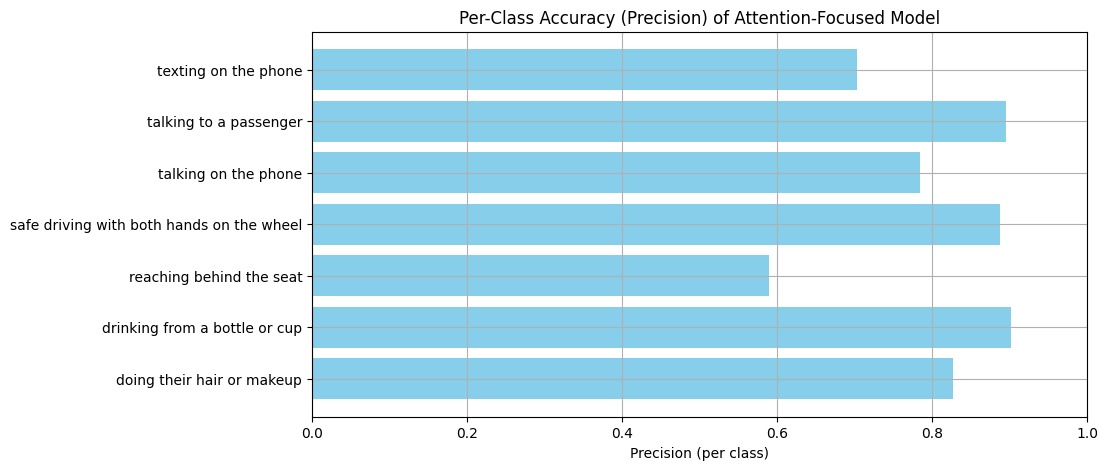

In [ ]:
#accuracy for each class
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Get classification report
report = classification_report(y_val, y_val_pred, output_dict=True)
classes = list(report.keys())[:-3]  # remove avg/total keys
accuracies = [report[label]['precision'] for label in classes]

# Plot accuracy per class
plt.figure(figsize=(10,5))
plt.barh(classes, accuracies, color='skyblue')
plt.xlabel("Precision (per class)")
plt.title("Per-Class Accuracy (Precision) of Attention-Focused Model")
plt.xlim(0, 1.0)
plt.grid(True)
plt.show()


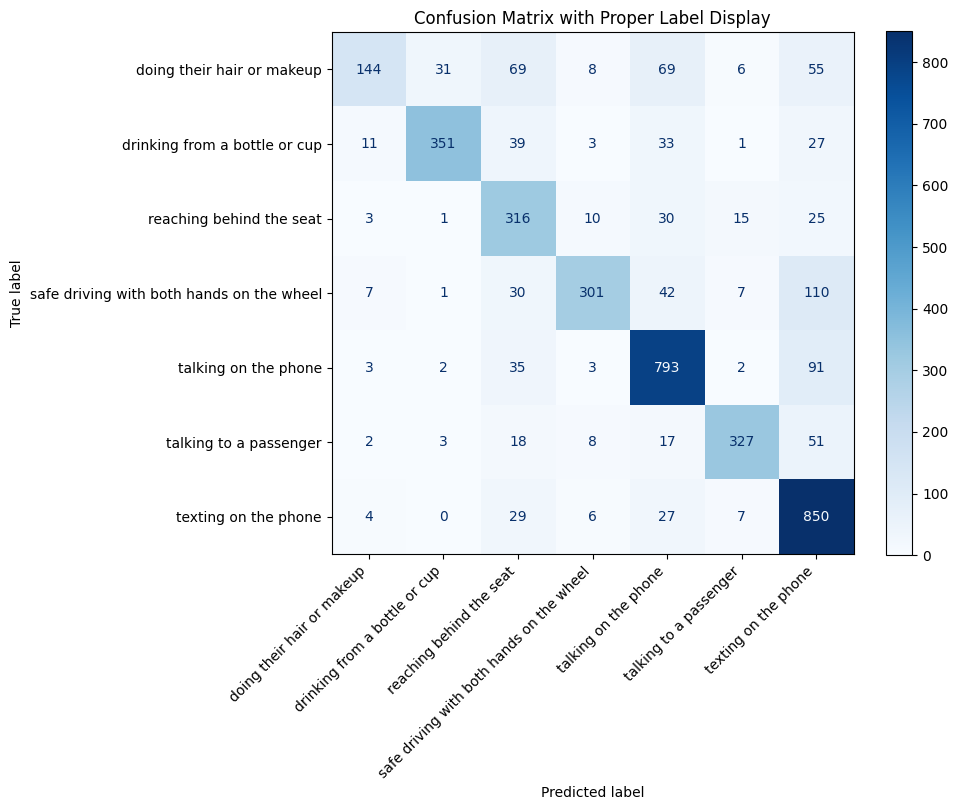

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y_val))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))

fig, ax = plt.subplots(figsize=(10, 8))  # You can increase figure size if needed
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)

# Optional: Improve tick spacing and alignment
plt.xticks(rotation=45, ha='right')  # Rotate x-axis and align text
plt.tight_layout()
plt.title("Confusion Matrix with Proper Label Display")
plt.show()


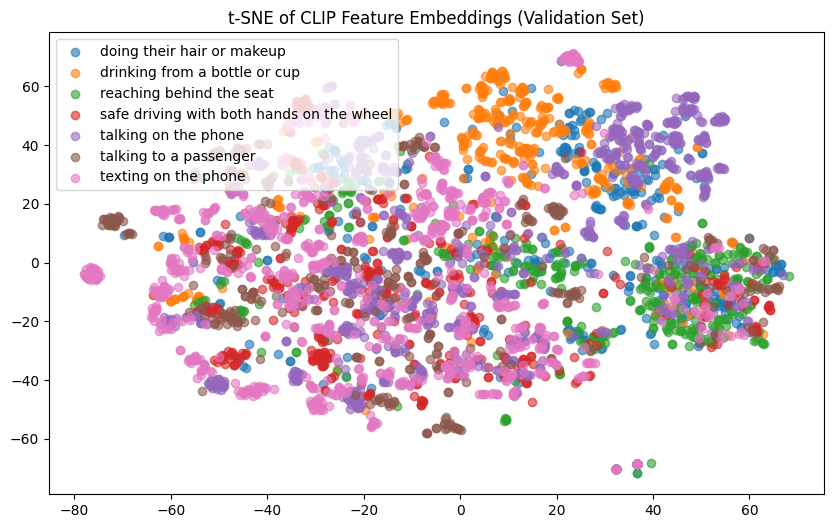

In [ ]:
#clustering
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
x_2d = tsne.fit_transform(x_val_feat)

plt.figure(figsize=(10,6))
for label in np.unique(y_val):
    idx = np.where(y_val == label)
    plt.scatter(x_2d[idx,0], x_2d[idx,1], label=label, alpha=0.6)
plt.legend()
plt.title("t-SNE of CLIP Feature Embeddings (Validation Set)")
plt.show()


In [2]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --clear-output --inplace your_notebook.ipynb


[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 